In [2]:
from pykrx import stock
from pykrx import bond

In [3]:
import pandas as pd

# 세 개의 DataFrame 생성
df_ohlcv = stock.get_market_ohlcv("20220101", "20231231", "005930")
df_fundamental = stock.get_market_fundamental("20220101", "20231231", "005930")
df_foreign_investment = stock.get_exhaustion_rates_of_foreign_investment("20220101", "20231231", "005930")

# 열 기준으로 결합
df_combined = pd.concat([df_ohlcv, df_fundamental, df_foreign_investment], axis=1, join="inner")

df_combined.to_csv("your_data.csv", encoding="utf-8-sig", index=True)

# 결과 확인
print(df_combined.head(3))




               시가     고가     저가     종가       거래량       등락률    BPS    PER  \
날짜                                                                         
2022-01-03  79400  79800  78200  78600  13502112  0.383142  39406  20.46   
2022-01-04  78800  79200  78300  78700  12427416  0.127226  39406  20.49   
2022-01-05  78800  79000  76400  77400  25470640 -1.651842  39406  20.15   

             PBR   EPS   DIV   DPS       상장주식수        보유수량       지분율  \
날짜                                                                     
2022-01-03  1.99  3841  3.81  2994  5969782550  3099478430  51.90625   
2022-01-04  2.00  3841  3.80  2994  5969782550  3102550526  51.96875   
2022-01-05  1.96  3841  3.87  2994  5969782550  3103048671  51.96875   

                  한도수량     한도소진률  
날짜                                
2022-01-03  5969782550  51.90625  
2022-01-04  5969782550  51.96875  
2022-01-05  5969782550  51.96875  


### Test

In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# 데이터 로드
data = pd.read_csv("your_data.csv")

# 데이터 전처리
data['날짜'] = pd.to_datetime(data['날짜'])
data = data.sort_values('날짜')
scaler = MinMaxScaler()
data[['종가', '고가', 'PER', '보유수량']] = scaler.fit_transform(data[['종가', '고가', 'PER', '보유수량']])

# 학습/테스트 데이터 분할
train_data = data[(data['날짜'] >= '2022-01-01') & (data['날짜'] <= '2023-06-30')]
test_data = data[(data['날짜'] >= '2023-07-01') & (data['날짜'] <= '2023-12-31')]

X_train = []
y_train = []
X_test = []
y_test = []

# 시계열 데이터 준비 (15일을 기준으로 입력 데이터 생성)
window_size = 15

for i in range(window_size, len(train_data)):
    X_train.append(train_data[['고가', 'PER', '보유수량']].values[i-window_size:i])
    y_train.append(train_data['종가'].values[i])

for i in range(window_size, len(test_data)):
    X_test.append(test_data[['고가', 'PER', '보유수량']].values[i-window_size:i])
    y_test.append(test_data['종가'].values[i])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# 모델 정의
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(units=50, return_sequences=True))
model.add(GRU(units=50))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer=Adam(), loss='mean_squared_error')

# 모델 학습
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# 예측
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.concatenate((predicted_prices, np.zeros((predicted_prices.shape[0], 3))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 3))), axis=1))[:, 0]

# 예측 결과와 실제 값 비교
predicted_vs_actual = pd.DataFrame({'Actual': y_test_actual, 'Predicted': predicted_prices})
print(predicted_vs_actual.head())


2024-11-15 10:54:08.523779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 10:54:09.084524: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 10:54:09.301682: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 10:54:10.823190: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-15 10:54:15.601596: W tensorflow/compiler/tf2

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 214ms/step - loss: 0.1601 - val_loss: 0.0144
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0309 - val_loss: 0.0055
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0085 - val_loss: 0.0254
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0152 - val_loss: 0.0049
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0048 - val_loss: 0.0208
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0064 - val_loss: 0.0103
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0043 - val_loss: 0.0057
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0044 - val_loss: 0.0133
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0038 - val_loss: 0.0174
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0034 - val_loss: 0.0104
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0035 - val_loss: 0.0104
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0031 - val_loss: 0.0136

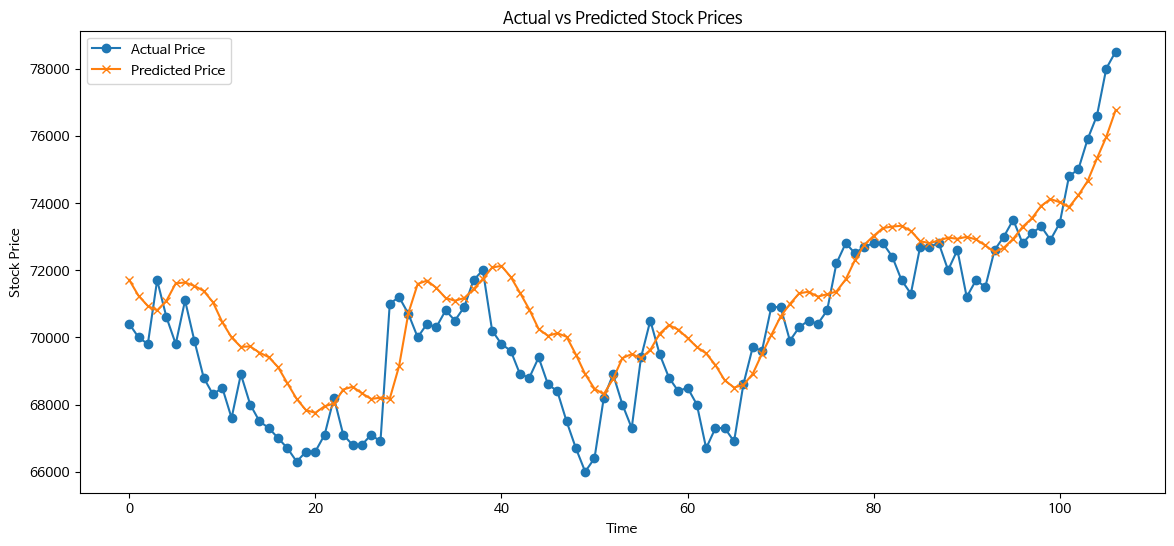

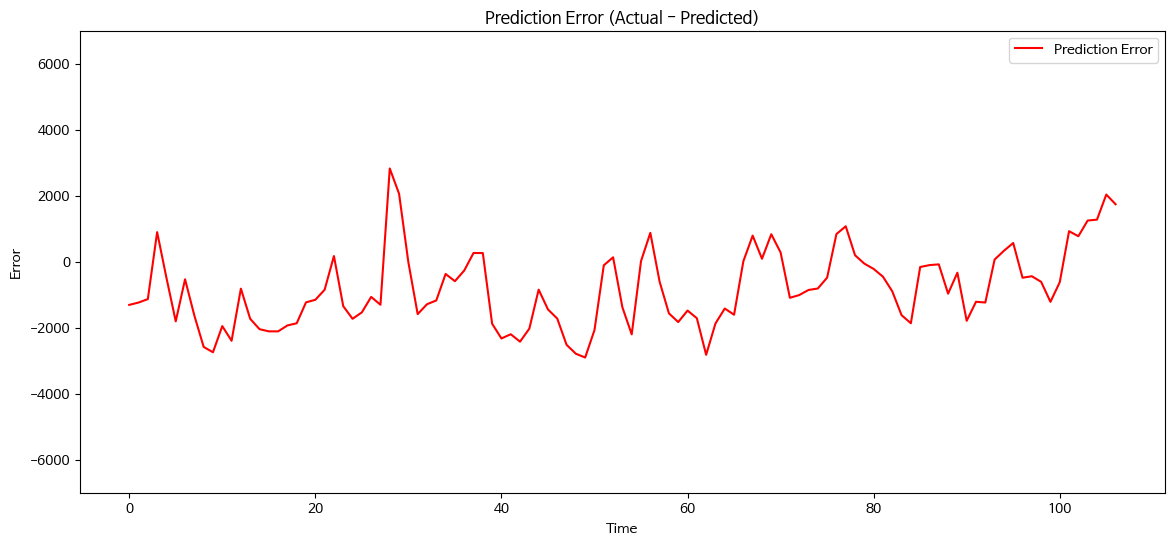

In [5]:
import matplotlib.pyplot as plt

# 오차 계산
predicted_vs_actual['Error'] = predicted_vs_actual['Actual'] - predicted_vs_actual['Predicted']

# 예측 값과 실제 값 비교 그래프
plt.figure(figsize=(14, 6))
plt.plot(predicted_vs_actual['Actual'], label='Actual Price', marker='o')
plt.plot(predicted_vs_actual['Predicted'], label='Predicted Price', marker='x')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# 오차 그래프
plt.figure(figsize=(14, 6))
plt.plot(predicted_vs_actual['Error'], label='Prediction Error', color='red')
plt.ylim(-7000, 7000)
plt.title('Prediction Error (Actual - Predicted)')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.show()


### Predict 2024 (for 50 days)

In [6]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# 데이터 로드
data = pd.read_csv("your_data.csv")

# 데이터 전처리
data['날짜'] = pd.to_datetime(data['날짜'])
data = data.sort_values('날짜')
scaler = MinMaxScaler()
data[['종가', '고가', 'PER', '보유수량']] = scaler.fit_transform(data[['종가', '고가', 'PER', '보유수량']])

# 학습 데이터 준비 (2019년부터 2023년까지)
train_data = data[(data['날짜'] >= '2022-01-01') & (data['날짜'] <= '2023-12-31')]

X_train = []
y_train = []
window_size = 15

for i in range(window_size, len(train_data)):
    X_train.append(train_data[['고가', 'PER', '보유수량']].values[i-window_size:i])
    y_train.append(train_data['종가'].values[i])

X_train, y_train = np.array(X_train), np.array(y_train)

# 모델 정의
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(units=50, return_sequences=True))
model.add(GRU(units=50))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer=Adam(), loss='mean_squared_error')

# 모델 학습
model.fit(X_train, y_train, epochs=50, batch_size=64)

# 2024년 예측 준비
# 마지막 15일 데이터로부터 50일 데이터를 순차적으로 예측
predicted_prices = []
last_window = train_data[['고가', 'PER', '보유수량']].values[-window_size:]

for day in range(50):  # 50일 예측
    x_input = last_window.reshape((1, window_size, 3))
    predicted_price = model.predict(x_input)
    
    predicted_prices.append(predicted_price[0][0])
    
    # 예측한 값을 윈도우에 추가하여 다음 예측에 사용
    last_window = np.append(last_window[1:], [[predicted_price[0][0], last_window[-1][1], last_window[-1][2]]], axis=0)

# 예측 결과 스케일 원상 복구
predicted_prices = scaler.inverse_transform(np.concatenate((np.array(predicted_prices).reshape(-1, 1), 
                                                           np.zeros((50, 3))), axis=1))[:, 0]

# 예측 결과 출력
predicted_2024 = pd.DataFrame({
    '날짜': pd.date_range(start='2024-01-01', periods=50, freq='B'),  # 주말 및 휴일 제외한 영업일 기준
    '예측_종가': predicted_prices
})
print(predicted_2024.head())


/home/yim/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.1778
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0344
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0142
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0063
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0060
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0048
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0038
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0040
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0036
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0037
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0034
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0035
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0035
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0032
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0032
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━

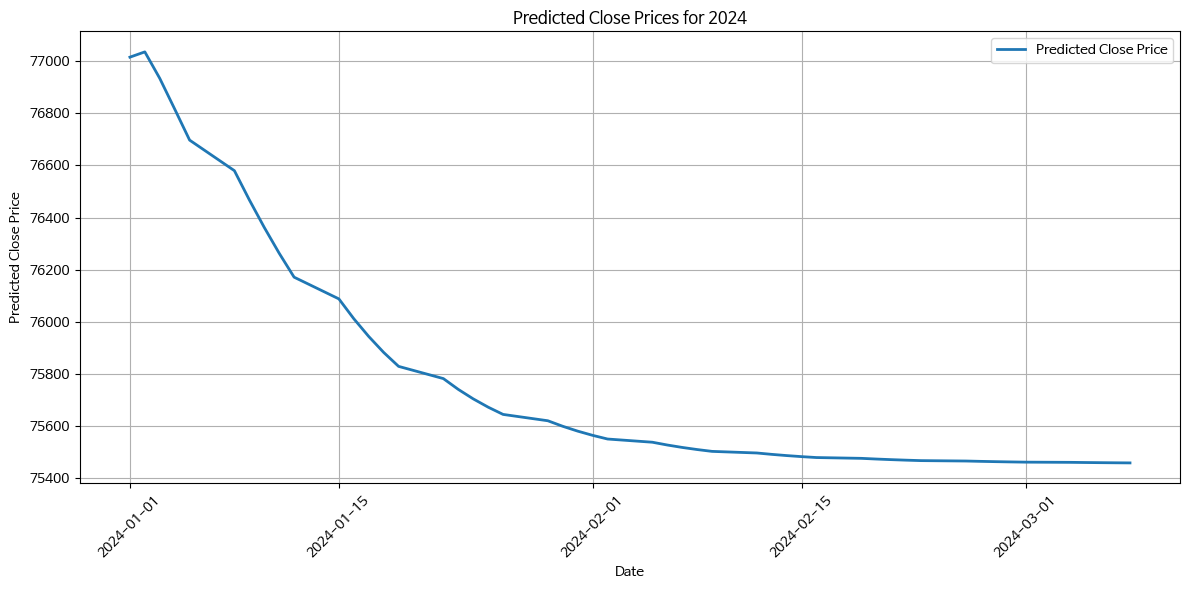

In [7]:
import matplotlib.pyplot as plt

# 그래프 설정
plt.figure(figsize=(12, 6))
plt.plot(predicted_2024['날짜'], predicted_2024['예측_종가'], label='Predicted Close Price', linewidth=2)

# 그래프 제목과 라벨 설정
plt.title("Predicted Close Prices for 2024")
plt.xlabel("Date")
plt.ylabel("Predicted Close Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # 날짜 라벨을 기울여서 표시

# 그래프 표시
plt.tight_layout()
plt.show()


In [8]:
print(predicted_2024)

           날짜         예측_종가
0  2024-01-01  77014.970946
1  2024-01-02  77035.214961
2  2024-01-03  76933.615530
3  2024-01-04  76816.014016
4  2024-01-05  76696.921712
5  2024-01-08  76579.716802
6  2024-01-09  76467.855847
7  2024-01-10  76362.240219
8  2024-01-11  76263.211656
9  2024-01-12  76171.370548
10 2024-01-15  76088.065034
11 2024-01-16  76012.025356
12 2024-01-17  75943.942827
13 2024-01-18  75882.859641
14 2024-01-19  75829.340136
15 2024-01-22  75782.490778
16 2024-01-23  75741.049647
17 2024-01-24  75704.751819
18 2024-01-25  75672.946739
19 2024-01-26  75645.120233
20 2024-01-29  75620.800453
21 2024-01-30  75599.557877
22 2024-01-31  75581.025684
23 2024-02-01  75564.868408
24 2024-02-02  75550.783503
25 2024-02-05  75538.510746
26 2024-02-06  75527.829105
27 2024-02-07  75518.530089
28 2024-02-08  75510.434991
29 2024-02-09  75503.390187
30 2024-02-12  75497.259295
31 2024-02-13  75491.926312
32 2024-02-14  75487.284642
33 2024-02-15  75483.246499
34 2024-02-16  75479

           날짜         예측_종가  실제_종가
0  2024-01-02  77035.214961  79600
1  2024-01-03  76933.615530  77000
2  2024-01-04  76816.014016  76600
3  2024-01-05  76696.921712  76600
4  2024-01-08  76579.716802  76500
5  2024-01-09  76467.855847  74700
6  2024-01-10  76362.240219  73600
7  2024-01-11  76263.211656  73200
8  2024-01-12  76171.370548  73100
9  2024-01-15  76088.065034  73900
10 2024-01-16  76012.025356  72600
11 2024-01-17  75943.942827  71000
12 2024-01-18  75882.859641  71700
13 2024-01-19  75829.340136  74700
14 2024-01-22  75782.490778  75100
15 2024-01-23  75741.049647  75200
16 2024-01-24  75704.751819  74000
17 2024-01-25  75672.946739  74100
18 2024-01-26  75645.120233  73400
19 2024-01-29  75620.800453  74400
20 2024-01-30  75599.557877  74300
21 2024-01-31  75581.025684  72700
22 2024-02-01  75564.868408  73600
23 2024-02-02  75550.783503  75200
24 2024-02-05  75538.510746  74300
25 2024-02-06  75527.829105  74400
26 2024-02-07  75518.530089  75000
27 2024-02-08  75510

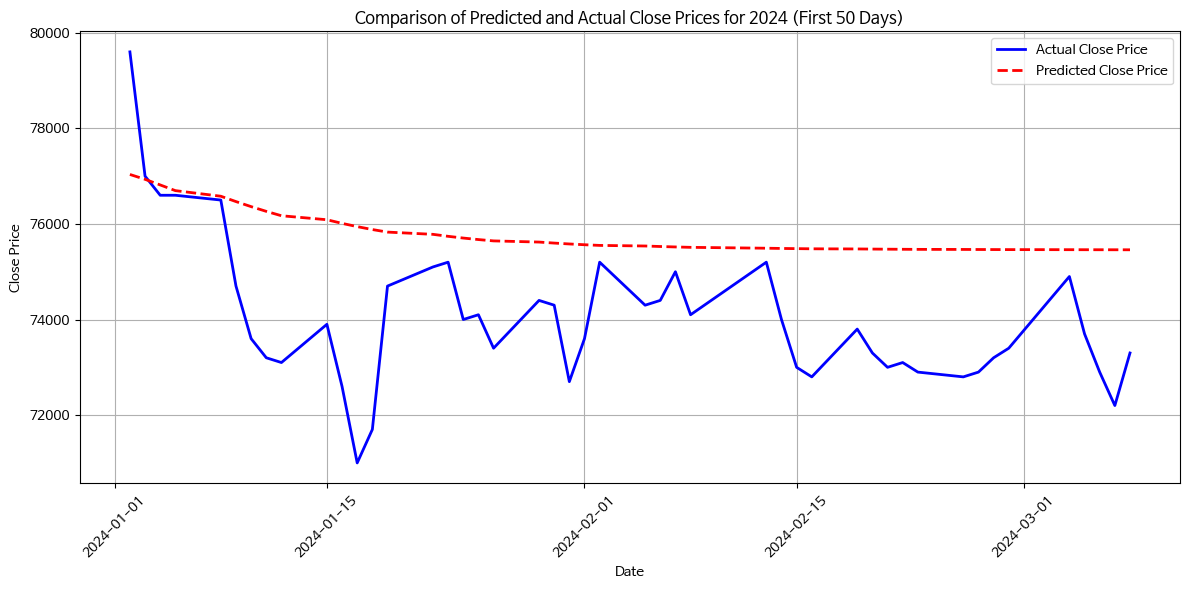

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2024년 실제 데이터 로드 (stock.get_market_ohlcv 사용)
df_ohlcv_2024 = stock.get_market_ohlcv("20240101", "20240311", "005930")

# 실제 데이터의 날짜 컬럼을 datetime 형식으로 변환하고, 필요한 열만 선택
df_ohlcv_2024.reset_index(inplace=True)  # 날짜를 인덱스에서 컬럼으로 변환
df_ohlcv_2024['날짜'] = pd.to_datetime(df_ohlcv_2024['날짜'])
actual_2024 = df_ohlcv_2024[['날짜', '종가']].reset_index(drop=True)

# 예측 데이터 생성
predicted_2024 = pd.DataFrame({
    '날짜': pd.date_range(start='2024-01-01', periods=50, freq='B'),  # 50일 영업일 기준 날짜 생성
    '예측_종가': predicted_prices
})

# 실제 데이터와 예측 데이터 병합
comparison_df = pd.merge(predicted_2024, actual_2024, on='날짜', how='inner')
comparison_df.rename(columns={'종가': '실제_종가'}, inplace=True)

# 예측 결과와 실제 값 비교 출력
print(comparison_df)

# 그래프로 예측값과 실제값 비교
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['날짜'], comparison_df['실제_종가'], label='Actual Close Price', color='blue', linewidth=2)
plt.plot(comparison_df['날짜'], comparison_df['예측_종가'], label='Predicted Close Price', color='red', linestyle='--', linewidth=2)

# 그래프 설정
plt.title("Comparison of Predicted and Actual Close Prices for 2024 (First 50 Days)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# 그래프 표시
plt.tight_layout()
plt.show()
